In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


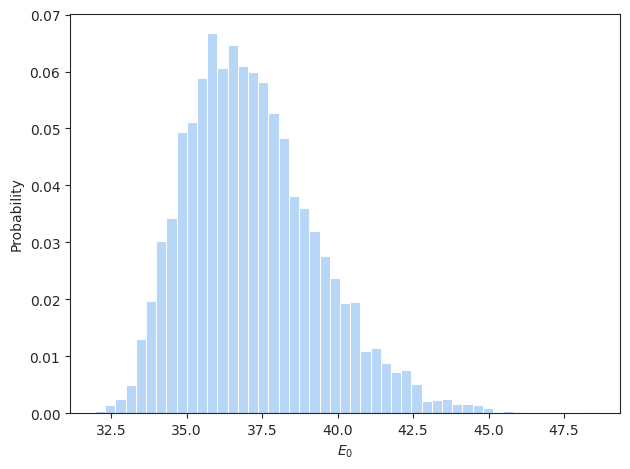

In [6]:
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

from nonlocalgames import methods
from nonlocalgames.hamiltonians import G14

values = []
ham = G14(init_mode='normal')
for i in range(5000):
    ham.init(seed=i)
    w, _ = eigsh(ham.mat, k=1, which='LA')
    values.append(w.item())

sns.histplot(data=values, stat='probability')
plt.xlabel('$E_0$')
plt.tight_layout()
plt.savefig('plots/g14/g14_random_init.png', dpi=300)

In [9]:
import json
import logging
import numpy as np
import pandas as pd
import gymnasium as gym
gym.logger.set_level(logging.CRITICAL)

from nonlocalgames import methods
from nonlocalgames.hamiltonians import G14

best_energy = np.inf
best_energies = None
best_ansatz, best_phi = None, None

records = []

for i in range(50):
    ham = G14()
    energies, state, phi = methods.dual_phase_optim(ham, verbose=1, seed=i, tol=1e-6)
    energy = energies[-1]

    for iter_, e in enumerate(energies):
        records.append({
            'id': i,
            'iter': iter_ + 1,
            'energy': e,
        })
    
    if energy < best_energy:
        best_energy = energy
        best_energies = energies
        state = [(theta, str(gate)) for theta, gate in state]
        best_ansatz = state
        best_phi = phi.reshape(2, 14, 2).tolist()

        with open('data/g14_state.json', 'w', encoding='utf-8') as f:
            json.dump({
                'state': best_ansatz,
                'phi': best_phi,
                'energies': best_energies
            }, f)

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_trials.csv', index=False)

Iter 1
-----------


KeyboardInterrupt: 

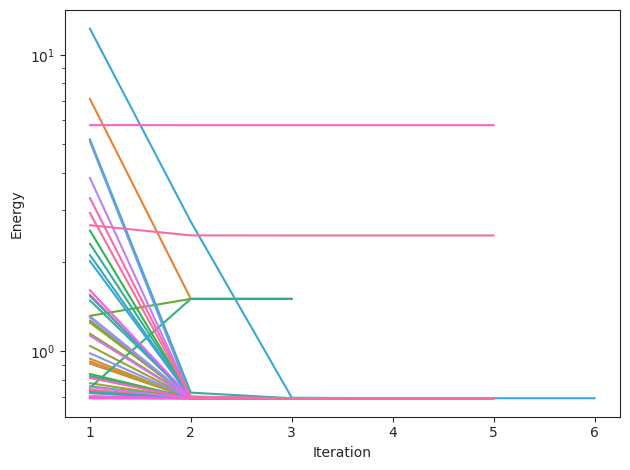

In [11]:
import pandas as pd

df = pd.read_csv('data/g14_trials.csv')
sns.lineplot(data=df, x='iter', y='energy', hue=df.id.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/g14_trials.png', dpi=300)